# 线性回归的从零开始

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集

为了简单起⻅，我们将根据带有噪声 $\epsilon$ 的线性模型构造⼀个⼈造数据集。我们的任务是使⽤这个有限样本的数据集来恢复这个模型的参数。我们将使⽤低维数据，这样可以很容易地将其可视化。

使用线性模型w=$\begin{bmatrix}2 & -3.4\end{bmatrix}^\top$,$b=4.2$和噪声项$\epsilon$生成数据集和标签
$$
y=XW+b+\epsilon
$$

In [2]:
def synthetic_data(w, b, num_examples):  # @save
    """
    生成y=Xw+b+噪声
    """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = X@w + b
    y += torch.normal(0, 0.01, y.shape)  # 添加噪声
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
# 查看生成结果
print('features:', features[0], '\nlabels:', labels[0])

features: tensor([-0.0981, -2.1286]) 
labels: tensor([11.2437])


通过生成第二个特征features[:,1]和labels的散点图，可以直接观察到两者之间的线性关系

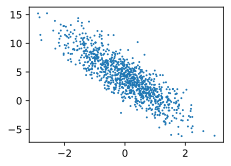

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

## 读取数据集

训练模型时要对数据集进⾏遍历，每次抽取⼀⼩批量样本，并使⽤它们来更新我们的模型。由于这个过程是训练机器学习算法的基础，所以有必要定义⼀个函数，该函数能打乱数据集中的样本并以⼩批量⽅式获取数据。

In [6]:
# 定义⼀个data_iter函数，该函数接收批量⼤⼩、特征矩阵和标签向量作为输⼊
# ⽣成⼤⼩为batch_size的⼩批量。每个⼩批量包含⼀组特征和标签。
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [7]:
# 调用函数，生成批量数据
batch_size = 16

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break  # 仅生成一次

tensor([[ 0.1802, -0.0417],
        [ 1.6016,  0.8430],
        [-0.6692,  0.1117],
        [ 1.1780, -0.1905],
        [ 0.4242,  0.3224],
        [-0.8359,  0.2187],
        [-0.1989, -0.1555],
        [ 0.1348, -1.1685],
        [-0.2425, -0.3908],
        [ 0.8116, -0.2891],
        [ 0.3664, -0.3175],
        [-1.3264,  0.3462],
        [-0.5921,  1.0177],
        [ 0.5677,  0.7112],
        [ 0.0862, -0.0075],
        [-0.0471, -1.3351]]) 
 tensor([[ 4.7199],
        [ 4.5133],
        [ 2.4795],
        [ 7.2153],
        [ 3.9674],
        [ 1.7747],
        [ 4.3212],
        [ 8.4387],
        [ 5.0522],
        [ 6.8126],
        [ 5.9908],
        [ 0.3867],
        [-0.4631],
        [ 2.9069],
        [ 4.4015],
        [ 8.6504]])


虽然上面实现的迭代对于教学来说很好，但它的执行效率很低，可能会再实际问题上陷入麻烦。例如，他要求我们将所有数据加载到内存中，并执行大量的随机内存访问。再深度学习框架中实现的内置迭代器效率要高得多，它可以处理存储在文件中的数据和数据流提供的数据。

## 初始化模型参数

In [8]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [9]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 定义损失函数

In [10]:
def squared_loss(y_hat, y):  #@save\
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

In [11]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练

In [12]:
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss
optim = sgd

In [13]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        y_hat = net(X, w, b)
        l = loss(y_hat, y)
        # 此时l的形状为(batch_size, 1)，而不是一个标量
        # 做批量梯度还需要将其进行累加，然后再求相关梯度
        l.sum().backward()  # 借用torch的自微分机制
        optim([w, b], lr, batch_size)
    print(f"epoch {epoch + 1}, loss{float(l.mean()):f}")

epoch 1, loss0.308875
epoch 2, loss0.021738
epoch 3, loss0.000500
epoch 4, loss0.000027
epoch 5, loss0.000065


因为我们使⽤的是⾃⼰合成的数据集，所以我们知道真正的参数是什么。因此，我们可以通过⽐较真实参数和通过训练学到的参数来评估训练的成功程度。事实上，真实参数和通过训练学到的参数确实⾮常接近。

In [14]:
print(f"w的估计误差：{true_w - w.reshape(true_w.shape)}")
print(f"b的估计误差：{true_b - b}")

w的估计误差：tensor([ 4.1914e-04, -5.4121e-05], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0006], grad_fn=<RsubBackward1>)


# 借用torch相关库进行简化实现过程

In [15]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

## 生成数据集

In [16]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

## 读取数据集

In [17]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [18]:
batch_size = 16
data_iter = load_array((features, labels), batch_size)

In [19]:
next(iter(data_iter))

[tensor([[ 0.5901,  2.6488],
         [ 0.4095,  0.1527],
         [-0.2090,  0.8720],
         [ 1.1937, -1.9312],
         [ 0.3959,  1.0894],
         [ 0.0704, -0.4367],
         [-0.4129,  1.9242],
         [ 0.6735, -1.0996],
         [ 0.7967,  1.0765],
         [ 0.0304, -1.0638],
         [-0.2701, -1.1600],
         [ 0.7544, -1.0759],
         [ 1.7778,  0.6517],
         [-0.5506,  1.5077],
         [-1.4695, -1.5066],
         [ 0.4394, -1.2276]]),
 tensor([[-3.6207],
         [ 4.4966],
         [ 0.8207],
         [13.1443],
         [ 1.2915],
         [ 5.8183],
         [-3.1769],
         [ 9.2673],
         [ 2.1265],
         [ 7.8799],
         [ 7.6129],
         [ 9.3694],
         [ 5.5437],
         [-2.0329],
         [ 6.3741],
         [ 9.2559]])]

## 定义模型

In [20]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

## 初始化模型参数

In [21]:
net[0].weight.data

tensor([[-0.6408,  0.6528]])

In [22]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## 定义损失函数

In [23]:
loss = nn.MSELoss()

## 定义优化算法

当我们实例化⼀个SGD实例时，我们要指定优化的参数（可通过net.parameters()从我们的模型中获得）以及优化算法所需的超参数字典。⼩批量随机梯度下降只需要设置lr值，这⾥设置为0.03。

In [24]:
trianer = torch.optim.SGD(net.parameters(), lr=0.03)

## 训练模型

In [25]:
num_epochs = 5

In [26]:
for epoch in range(num_epochs):
    for X, y in data_iter:
        y_pred = net(X)
        l = loss(y_pred, y)
        trianer.zero_grad()  # 梯度置零
        l.backward()  # 梯度回传
        trianer.step()  # 参数更新
    l =loss(net(features), labels)
    print(f"epoch{epoch + 1}, loss {l:f}")

epoch1, loss 0.019140
epoch2, loss 0.000103
epoch3, loss 0.000095
epoch4, loss 0.000095
epoch5, loss 0.000095


查看参数的训练误差

In [27]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0001,  0.0005])
b的估计误差： tensor([0.0006])


# 图像分类数据集

MNIST数据集 [LeCun et al., 1998] 是图像分类中⼴泛使⽤的数据集之⼀，但作为基准数据集过于简单。我们将使⽤类似但更复杂的Fashion-MNIST数据集 [Xiao et al., 2017]。

In [28]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

## 读取数据集

In [29]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=False)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=False)

Fashion-MNIST由10个类别的图像组成，每个类别由训练数据集（train dataset）中的60000张图像和测试数据集（test dataset）中的10000张图像组成。因此，训练集和测试集分别包含60000和10000张图像。

In [30]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [31]:
# 每张图片的尺寸
mnist_train[0][0].shape

torch.Size([1, 28, 28])

Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤⼦）、pullover（套衫）、dress（连⾐裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。

In [32]:
# 以下函数⽤于在数字标签索引及其⽂本名称之间进⾏转换。
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [33]:
# 可视化样本
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

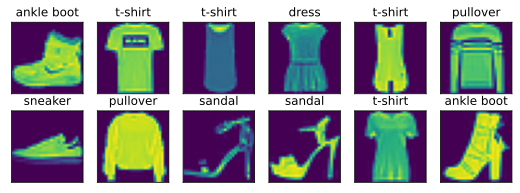

In [34]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=12)))
show_images(X.reshape(12, 28, 28), 2, 6, titles=get_fashion_mnist_labels(y));

## 读取小批量数据集

In [35]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())

In [36]:
# 查看读取数据花费的时间
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'2.43 sec'

## 整合所有组件

In [37]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """加载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=False)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [38]:
# 测试图像大小调整功能
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)

In [51]:
for X, y in train_iter:
    print(X.shape, X.dtype, '\n', y.shape, y.dtype)
    break

torch.Size([256, 1, 28, 28]) torch.float32 
 torch.Size([256]) torch.int64


# softmax回归的从零开始实现

In [40]:
import torch
from IPython import display
from d2l import torch as d2l

In [41]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

In [42]:
num_inputs = 784
num_outputs = 10

In [43]:
w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## 定义softmax操作

In [44]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

In [45]:
X = torch.normal(0, 1, (2, 5))

In [46]:
X_prob = softmax(X)
X_prob, X_prob.sum(1, keepdim=True)

(tensor([[0.0943, 0.2027, 0.5856, 0.0352, 0.0822],
         [0.2924, 0.0535, 0.0277, 0.3828, 0.2435]]),
 tensor([[1.0000],
         [1.0000]]))

注意，虽然这在数学上看起来是正确的，但我们在代码实现中有点草率。矩阵中的⾮常⼤或⾮常⼩的元素可能造成数值上溢或下溢，但我们没有采取措施来防⽌这点。

## 定义模型

In [47]:
X.shape

torch.Size([2, 5])

In [48]:
w.shape

torch.Size([784, 10])

In [49]:
def net(X):
    return softmax(X.reshape((-1, w.shape[0]))@w + b)

## 定义损失函数

In [50]:
# y为具体的类别
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [52]:
cross_entropy(net(X[:2]), y[:2])

tensor([2.2685, 2.3881], grad_fn=<NegBackward>)

## 分类精度

In [53]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    # 当y_hat是矩阵时
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [54]:
# 计算精度
accuracy(net(X[:100]), y[:100] ) / len(y[:100])

0.05

In [55]:
# 定义⼀个实⽤程序类Accumulator，⽤于对多个变量进⾏累加
class Accumulator:  #@save
    """在n个变量上进行累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a,b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [56]:
# 评估任意模型net的精度
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式，不会计算相关梯度
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [57]:
evaluate_accuracy(net, test_iter)

0.1261

## 训练

我们重构训练过程的实现以使其可重复使⽤。⾸先，我们定义⼀个函数来训练⼀个迭代周期。请注意，updater是更新模型参数的常⽤函数，它接受批量⼤⼩作为参数。它可以是d2l.sgd函数，也可以是框架的内置优化函数。

In [58]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用pytorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用自定义的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

在展⽰训练函数的实现之前，我们定义⼀个在动画中绘制数据的实⽤程序类Animator

In [59]:
class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()  # 使用矢量图显示图像
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使⽤lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [60]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics + (test_acc, ))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [61]:
lr = 0.1

In [62]:
def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

现在，我们训练模型10个迭代周期。请注意，迭代周期（num_epochs）和学习率（lr）都是可调节的超参数。通过更改它们的值，我们可以提⾼模型的分类精度。

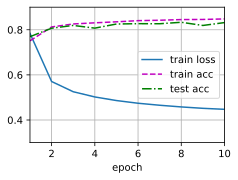

In [63]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 预测

In [64]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    y_pred = net(X).argmax(axis=1)
    preds = d2l.get_fashion_mnist_labels(y_pred)
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[:n].reshape((n, 28, 28)), 1, n, titles=titles[:n])

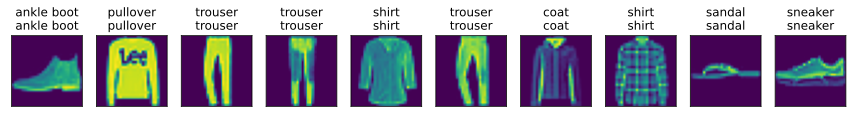

In [65]:
predict_ch3(net, test_iter, n=10)

# softmax回归简洁实现

In [66]:
import torch
from torch import nn
from d2l import torch as d2l

In [67]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [68]:
# PyTorch不会隐式地调整输⼊的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整⽹络输⼊的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

In [69]:
loss = nn.CrossEntropyLoss(reduction='none')

In [70]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

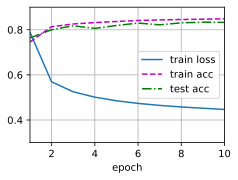

In [71]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)